1. Importing libraries

In [2]:
import sys
print("Python version")
print(sys.version)

Python version
3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]


In [99]:
import pandas as pd
import sklearn
import joblib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
import numpy as np

In [100]:
pd.set_option("display.max_columns", None)

In [101]:
sklearn.set_config(transform_output="default")

In [102]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [103]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)

In [104]:
X_train , y_train = split_data(train_df)
X_val , y_val = split_data(val_df)
X_test , y_test = split_data(test_df)

In [105]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [106]:
# data preprocessing
num_cols = ["duration", "total_stops"]
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]
cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]


In [107]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format = "mixed")),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline( steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=[ "day_of_week", "day_of_month"], format = "mixed")),
    ("scaler", StandardScaler())
])

In [108]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time", "arrival_time"])
])

In [109]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.43569944,  0.31797533,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.82441239,  1.84808218,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.94641325, -1.21213152,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18982461,  0.31797533,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63833955,  0.31797533,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [110]:
# model_selection
algorithms = {
    "Linear Regressor": LinearRegression(),
    "Support Vector Machine":SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10)
}

In [111]:
# combine X_train and x_val
data = pd.concat([train_df, val_df], axis=0)


In [112]:
X_data, y_data = split_data(data)

In [113]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [114]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

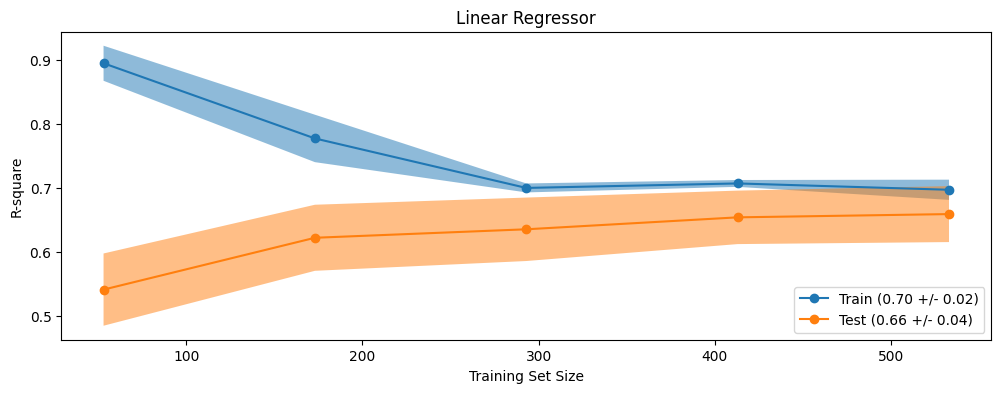

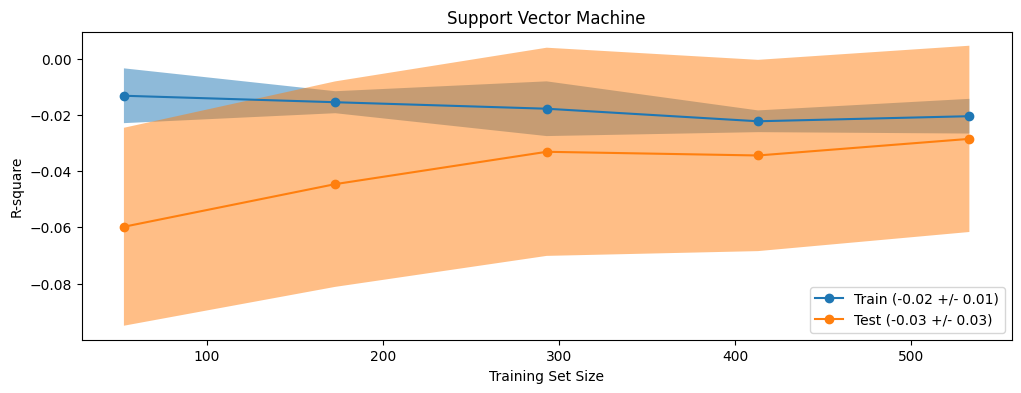

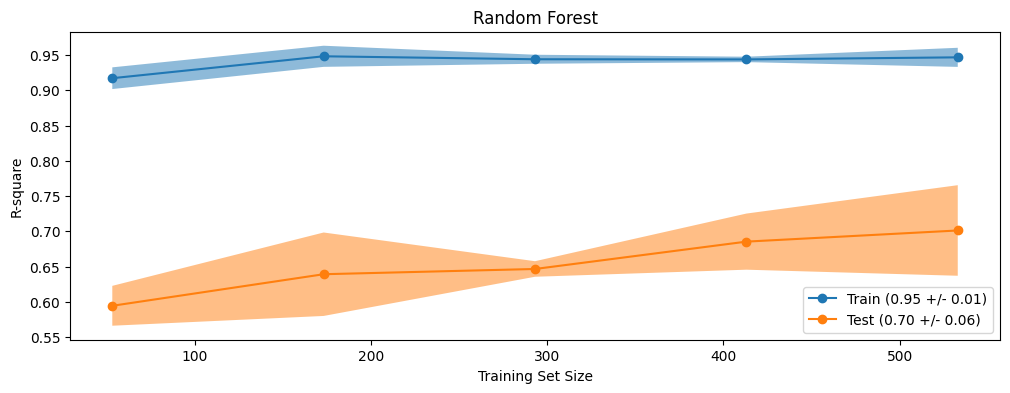

In [115]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

In [116]:
# model training
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=10))
])

In [117]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['day_of_week',
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [118]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [119]:
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")

R2 score on Training data is = 0.9505329824390509


In [120]:
print(f"R2 score on Training data is = {evaluate_model(X_test, y_test)}")

R2 score on Training data is = 0.7676107427382943


In [121]:
# Model persistance
joblib.dump(model,"model.joblib")

['model.joblib']

In [122]:
saved_model = joblib.load("model.joblib")

In [123]:
y_pred = saved_model.predict(X_test)
r2_score(y_test, y_pred)

0.7676107427382943